# A tail of two cities
An exploratory analysis comparing the rainfall patterns of Perth to Melbourne using `pandas` and `seaborn`

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()

In [6]:
#import data which can be sourced from Austalian BoM www.bom.gov.au
col_names = ['code','station_id','year','month','day','rainfall','period','quality']
perth = pd.read_csv('.\\rain_perth.csv', names=col_names, header=0)
melb = pd.read_csv('.\\rain_melbourne.csv', names=col_names, header=0) #i have chosen melbourne airport as the reference here
perth.head()

,code,station_id,year,month,day,rainfall,period,quality
0,IDCJAC0009,9225,1993,1,1,NaN,NaN,NaN
1,IDCJAC0009,9225,1993,1,2,NaN,NaN,NaN
2,IDCJAC0009,9225,1993,1,3,NaN,NaN,NaN
3,IDCJAC0009,9225,1993,1,4,NaN,NaN,NaN
4,IDCJAC0009,9225,1993,1,5,NaN,NaN,NaN


In [7]:
#combine year, month, day columns into a datetime index
perth = perth.set_index(pd.to_datetime(perth[['year','month','day']]))
melb = melb.set_index(pd.to_datetime(melb[['year','month','day']]))

#select a 25 year common study period
perth_study = perth['1994':'2018']
melb_study = melb['1994':'2018']

## [1] Annual rainfall totals

C:\Users\User\Anaconda3\lib\site-packages\pandas\plotting\_matplotlib\converter.py:102: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


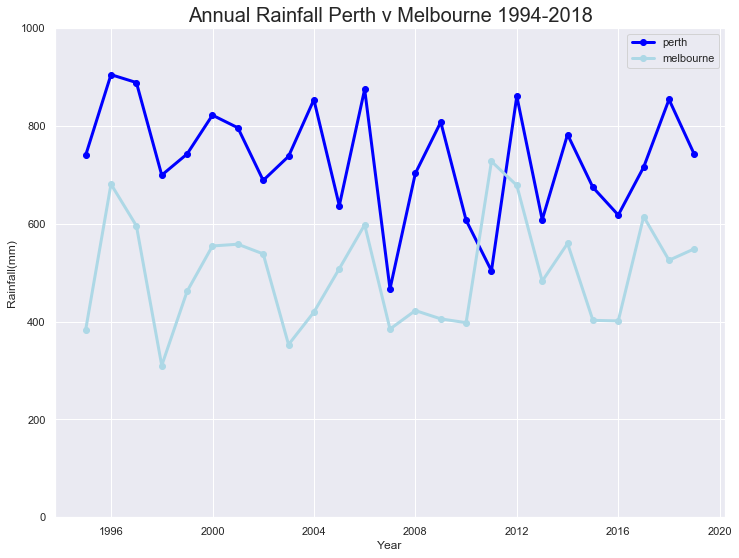

In [8]:
fig, ax = plt.subplots(figsize=(12,9))
ax.plot(perth_study.resample('A')[['rainfall']].sum(), marker='o', c='blue', lw=3, label='perth')
ax.plot(melb_study.resample('A')[['rainfall']].sum(), marker='o', c='lightblue', lw=3, label='melbourne')
ax.set_ylim(0,1000)
ax.legend()
ax.set(xlabel='Year', ylabel='Rainfall(mm)')
ax.set_title('Annual Rainfall Perth v Melbourne 1994-2018', fontdict={'fontsize': 20});

## [2] Monthly Averages

In [9]:
perth_monthly_avg = perth_study.pivot_table('rainfall', 'month', 'year', aggfunc='sum').mean(axis=1).rename('perth_mavg')
melb_monthly_avg = melb_study.pivot_table('rainfall', 'month', 'year', aggfunc='sum').mean(axis=1).rename('melb_mavg')
monthly_avg = pd.concat([perth_monthly_avg, melb_monthly_avg], axis=1)

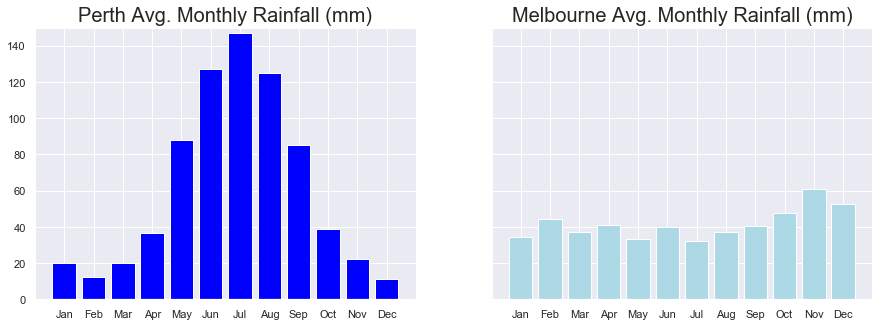

In [10]:
month_list = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
color_list = ['blue','lightblue']
title_list =['Perth','Melbourne']

fig, axes = plt.subplots(1,2, sharey=True, figsize=(15,5))

for i, ax in enumerate(axes.flatten()):
    ax.bar(x=range(1,13), height=monthly_avg.iloc[:,i], color=color_list[i])
    ax.set_title(title_list[i] + ' Avg. Monthly Rainfall (mm)', fontsize=20)
    ax.set_xticks(range(1,13))
    ax.set_xticklabels(month_list)
    ax.set_ylim(0,150);

# [3] Rainy day insights

In [11]:
#label each of the days as either wet or dry depending on rainfall
perth_study['wet_or_dry'] = np.nan
perth_study['wet_or_dry'] = np.where(perth_study.rainfall > 0, 'wet','dry')
melb_study['wet_or_dry'] = np.nan
melb_study['wet_or_dry'] = np.where(melb_study.rainfall > 0, 'wet','dry')

C:\Users\User\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\User\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\User\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value 

In [12]:
perth_wet_days = (perth_study[perth_study.wet_or_dry == 'wet'].
                  groupby(['year','month']).
                  size().
                  to_frame('wet_day_count').
                  reset_index())

In [13]:
melb_wet_days = (melb_study[melb_study.wet_or_dry == 'wet'].
                  groupby(['year','month']).
                  size().
                  to_frame('wet_day_count').
                  reset_index())

In [14]:
#lets concatenate the two data sets to enable plotting side by side
perth_wet_days['city'] = 'perth'
melb_wet_days['city'] = 'melbourne'
combined_wet_days = pd.concat([perth_wet_days, melb_wet_days])

#output the average number of rainy days per year for each city
display(combined_wet_days.groupby(['year','city'])[['wet_day_count']].sum().unstack('city').mean())

               city     
wet_day_count  melbourne    135.64
               perth        109.12
dtype: float64

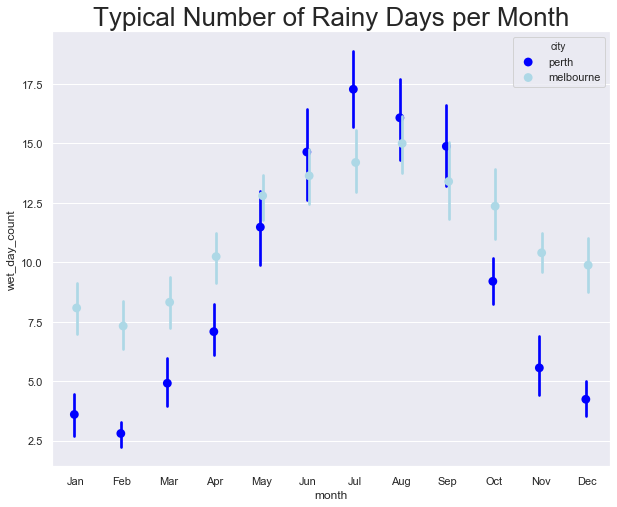

In [15]:
plt.figure(figsize=(10,8))
sns.pointplot(x='month', y='wet_day_count', hue='city', data=combined_wet_days, dodge=True, join=None,
             palette=sns.color_palette(['blue', 'lightblue']))
plt.title('Typical Number of Rainy Days per Month', fontsize=26)
plt.xticks(range(12), labels=month_list);

## How much rain falls on those rainy days?

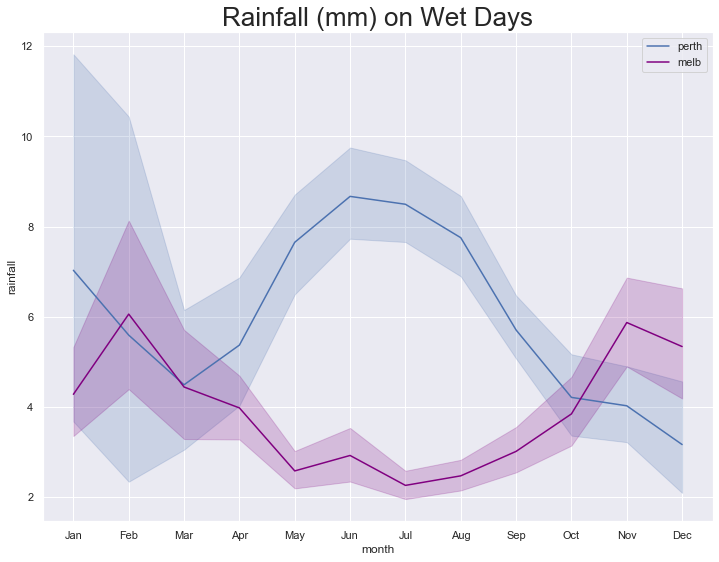

In [16]:
plt.figure(figsize=(12,9))
sns.lineplot(x='month', y='rainfall', data=perth_study.query("wet_or_dry == 'wet'"), color='b', label='perth')
sns.lineplot(x='month', y='rainfall', data=melb_study.query("wet_or_dry == 'wet'"), color='purple', label='melb')
plt.title('Rainfall (mm) on Wet Days', fontsize=26)
plt.xticks(range(1,13), labels=month_list);